In [1]:
import csv
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms.functional import crop

In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import cv2

In [3]:
im_transform = transforms.Compose([
    #transforms.Resize(64),
    transforms.ToTensor(),
])

IMAGE_PATH = 'archive/data/train_data/';

train_ids = []

for png in tqdm(os.listdir('archive/data/train_data')):
    train_ids.append(png)
    

100%|████████████████████████████████████████████████████████████████████████| 10913/10913 [00:00<00:00, 564917.49it/s]


In [4]:
test_ids = []

for png in tqdm(os.listdir('archive/test/test_data')):
    test_ids.append(png)

100%|████████████████████████████████████████████████████████████████████████████| 814/814 [00:00<00:00, 411642.57it/s]


In [5]:
class ImageDiskLoader(torch.utils.data.Dataset):

    def __init__(self, im_ids):
        self.transform = im_transform
        self.im_ids = im_ids

    def __len__(self):
        return len(self.im_ids)

    def __getitem__(self, idx):
        im_path = IMAGE_PATH + self.im_ids[idx]
        im = Image.open(im_path)
        #im = crop(im, 30, 0, 178, 178)
        data = self.transform(im)
        
        return data

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Input 64x64x3.
# Adam 1e-4
# Encoder Conv 32x4x4 (stride 2), 32x4x4 (stride 2), 64x4x4 (stride 2),
# 64x4x4 (stride 2), FC 256. ReLU activation.
# Latents 32
# Decoder Deconv reverse of encoder. ReLU activation. Gaussian.


class BetaVAE(nn.Module):

    def __init__(self, latent_size=32, beta=1):
        super(BetaVAE, self).__init__()

        self.latent_size = latent_size
        self.beta = beta

        # encoder
        self.encoder = nn.Sequential(
            self._conv(3, 32),
            self._conv(32, 32),
            self._conv(32, 64),
            self._conv(64, 64),
        )
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_var = nn.Linear(256, latent_size)

        # decoder
        self.decoder = nn.Sequential(
            self._deconv(64, 64),
            self._deconv(64, 32),
            self._deconv(32, 32, 1),
            self._deconv(32, 3),
            nn.Sigmoid()
        )
        self.fc_z = nn.Linear(latent_size, 256)

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256)
        return self.fc_mu(x), self.fc_var(x)

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # e^(1/2 * log(std^2))
        eps = torch.randn_like(std)  # random ~ N(0, 1)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        z = self.fc_z(z)
        z = z.view(-1, 64, 2, 2)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        rx = self.decode(z)
        return rx, mu, logvar

    def _conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels,
                kernel_size=4, stride=2
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )


    def _deconv(self, in_channels, out_channels, out_padding=0):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels,
                kernel_size=4, stride=2, output_padding=out_padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def loss(self, recon_x, x, mu, logvar):
        
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')


        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kl_diverge = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return (recon_loss + self.beta * kl_diverge) / x.shape[0]  # divide total loss by batch size

In [7]:
import torch
import torch.optim as optim
import multiprocessing
import time
from torchvision.utils import save_image

In [8]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output, mu, logvar = model(data)
        loss = model.loss(output, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()), epoch, batch_idx * len(data),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader)
    print('Train set Average loss:', train_loss)
    return train_loss


def test(model, device, test_loader, return_images=0, log_interval=None):
    model.eval()
    test_loss = 0

    # two np arrays of images
    original_images = []
    rect_images = []

    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            data = data.to(device)
            output, mu, logvar = model(data)
            loss = model.loss(output, data, mu, logvar)
            test_loss += loss.item()

            if return_images > 0 and len(original_images) < return_images:
                original_images.append(data[0].cpu())
                rect_images.append(output[0].cpu())

            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), loss.item()))

    test_loss /= len(test_loader)
    print('Test set Average loss:', test_loss)

    if return_images > 0:
        return test_loss, original_images, rect_images

    return test_loss

In [9]:
# parameters
BATCH_SIZE = 64
TEST_BATCH_SIZE = 10
EPOCHS = 20

LATENT_SIZE = 100
LEARNING_RATE = 1e-3

USE_CUDA = True
PRINT_INTERVAL = 100
LOG_PATH = './logs/log.pkl'
MODEL_PATH = './checkpoints/'
COMPARE_PATH = './comparisons/'

In [10]:
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

data_train = ImageDiskLoader(train_ids)
data_test =  ImageDiskLoader(test_ids)

In [11]:
kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

In [12]:
model = BetaVAE(latent_size=LATENT_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
start_epoch =  1
train_losses = []
test_losses = []

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)

    train_losses.append((epoch, train_loss))

Fri May 14 18:57:30 2021 Train Epoch: 1 [0/10913 (0%)]	Loss: 8462.796875
Fri May 14 18:58:43 2021 Train Epoch: 1 [6400/10913 (58%)]	Loss: 7330.905762
Train set Average loss: 7546.199572825292
Fri May 14 18:59:34 2021 Train Epoch: 2 [0/10913 (0%)]	Loss: 7195.312988
Fri May 14 19:00:27 2021 Train Epoch: 2 [6400/10913 (58%)]	Loss: 7118.971191
Train set Average loss: 7142.79320575201
Fri May 14 19:01:05 2021 Train Epoch: 3 [0/10913 (0%)]	Loss: 7128.727539
Fri May 14 19:02:02 2021 Train Epoch: 3 [6400/10913 (58%)]	Loss: 7047.419434
Train set Average loss: 7018.765128152412
Fri May 14 19:02:40 2021 Train Epoch: 4 [0/10913 (0%)]	Loss: 7046.187012
Fri May 14 19:03:34 2021 Train Epoch: 4 [6400/10913 (58%)]	Loss: 6858.835938
Train set Average loss: 6945.315418265716
Fri May 14 19:04:12 2021 Train Epoch: 5 [0/10913 (0%)]	Loss: 6892.464355
Fri May 14 19:05:06 2021 Train Epoch: 5 [6400/10913 (58%)]	Loss: 6917.933105
Train set Average loss: 6899.170004682931
Fri May 14 19:05:45 2021 Train Epoch: 6 [

In [14]:
import torch.optim as optim
import multiprocessing
import time
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [15]:
def generate(model, num, device):
    model.eval()
    z = torch.randn(num, model.latent_size).to(device)
    with torch.no_grad():
        return model.decode(z).cpu()

In [16]:
some = generate(model,3,device)

In [17]:
import os
import glob
import re
import pickle

In [18]:
def show_images(images, titles=None, columns=5, max_rows=5, path=None, tensor=False):
    """
    Args:
        images(list[np.array]): Images to show
        titles(list[string]): Titles for each of the images
        columns(int): How many columns to use in the tiling
        max_rows(int): If there are more than columns * max_rows images,
        only the first n of them will be shown.
    """

    images = images[:min(len(images), max_rows * columns)]

    if tensor:
        images = [np.transpose(im, (1, 2, 0)) for im in images]

    plt.figure(figsize=(20, 10))
    for ii, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, ii + 1)
        plt.axis('off')
        if titles is not None and ii < len(titles):
            plt.title(str(titles[ii]))
        plt.imshow(image)

    if path is not None and os.path.exists(os.path.dirname(path)):
        plt.savefig(path)
    else:
        plt.show()

<ipython-input-18-2b7accf13b3d>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, ii + 1)


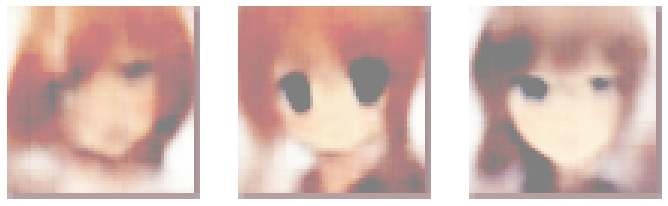

In [19]:
show_images(some, tensor=True)

In [20]:
start_epoch =  21


for epoch in range(start_epoch, 30 + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)

    train_losses.append((epoch, train_loss))

Sat May 15 16:03:47 2021 Train Epoch: 21 [0/10913 (0%)]	Loss: 6875.825195
Sat May 15 16:05:57 2021 Train Epoch: 21 [6400/10913 (58%)]	Loss: 6670.498047
Train set Average loss: 6765.257843909905
Sat May 15 16:07:21 2021 Train Epoch: 22 [0/10913 (0%)]	Loss: 6714.657715
Sat May 15 16:08:20 2021 Train Epoch: 22 [6400/10913 (58%)]	Loss: 6815.699219
Train set Average loss: 6762.307771381579
Sat May 15 16:09:08 2021 Train Epoch: 23 [0/10913 (0%)]	Loss: 6798.618164
Sat May 15 16:10:13 2021 Train Epoch: 23 [6400/10913 (58%)]	Loss: 6735.847656
Train set Average loss: 6762.072725351791
Sat May 15 16:10:55 2021 Train Epoch: 24 [0/10913 (0%)]	Loss: 6755.505859
Sat May 15 16:11:56 2021 Train Epoch: 24 [6400/10913 (58%)]	Loss: 6709.267090
Train set Average loss: 6759.280687477157
Sat May 15 16:12:37 2021 Train Epoch: 25 [0/10913 (0%)]	Loss: 6795.162109
Sat May 15 16:13:34 2021 Train Epoch: 25 [6400/10913 (58%)]	Loss: 6811.888672
Train set Average loss: 6757.962048268458
Sat May 15 16:14:14 2021 Train

<ipython-input-18-2b7accf13b3d>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, ii + 1)


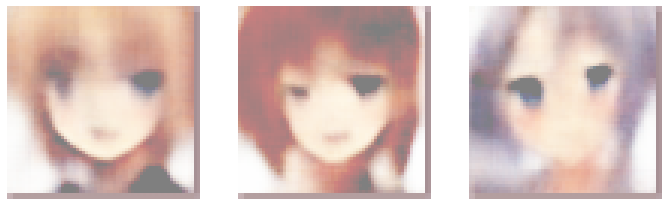

In [23]:
some = generate(model,3,device)
show_images(some, tensor=True)

In [24]:
start_epoch =  31


for epoch in range(start_epoch, 40 + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)

    train_losses.append((epoch, train_loss))

Sat May 15 16:24:05 2021 Train Epoch: 31 [0/10913 (0%)]	Loss: 6962.580566
Sat May 15 16:25:01 2021 Train Epoch: 31 [6400/10913 (58%)]	Loss: 6787.004395
Train set Average loss: 6750.979280884503
Sat May 15 16:25:43 2021 Train Epoch: 32 [0/10913 (0%)]	Loss: 6668.736328
Sat May 15 16:26:40 2021 Train Epoch: 32 [6400/10913 (58%)]	Loss: 6627.481445
Train set Average loss: 6749.364052220395
Sat May 15 16:27:19 2021 Train Epoch: 33 [0/10913 (0%)]	Loss: 6751.161133
Sat May 15 16:28:13 2021 Train Epoch: 33 [6400/10913 (58%)]	Loss: 6845.229492
Train set Average loss: 6748.643523277595
Sat May 15 16:28:51 2021 Train Epoch: 34 [0/10913 (0%)]	Loss: 6821.888672
Sat May 15 16:29:47 2021 Train Epoch: 34 [6400/10913 (58%)]	Loss: 6749.270508
Train set Average loss: 6747.252649853801
Sat May 15 16:30:25 2021 Train Epoch: 35 [0/10913 (0%)]	Loss: 6635.391113
Sat May 15 16:31:21 2021 Train Epoch: 35 [6400/10913 (58%)]	Loss: 6769.092773
Train set Average loss: 6746.6013397752195
Sat May 15 16:32:00 2021 Trai

<ipython-input-18-2b7accf13b3d>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, ii + 1)


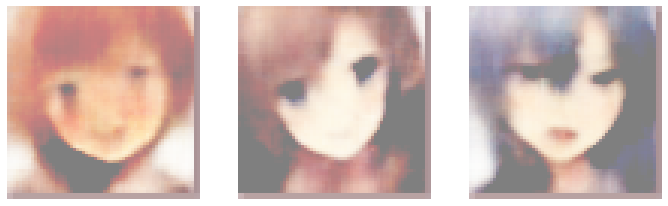

In [28]:
some = generate(model,3,device)
show_images(some, tensor=True)

In [29]:
start_epoch =  41


for epoch in range(start_epoch, 100 + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)

    train_losses.append((epoch, train_loss))

Sat May 15 16:41:39 2021 Train Epoch: 41 [0/10913 (0%)]	Loss: 6883.254883
Sat May 15 16:42:36 2021 Train Epoch: 41 [6400/10913 (58%)]	Loss: 6754.647461
Train set Average loss: 6740.723238760965
Sat May 15 16:43:16 2021 Train Epoch: 42 [0/10913 (0%)]	Loss: 6810.270996
Sat May 15 16:44:11 2021 Train Epoch: 42 [6400/10913 (58%)]	Loss: 6705.533691
Train set Average loss: 6739.340934530336
Sat May 15 16:44:49 2021 Train Epoch: 43 [0/10913 (0%)]	Loss: 6926.063477
Sat May 15 16:45:44 2021 Train Epoch: 43 [6400/10913 (58%)]	Loss: 6947.088867
Train set Average loss: 6739.670724255299
Sat May 15 16:46:23 2021 Train Epoch: 44 [0/10913 (0%)]	Loss: 6877.676758
Sat May 15 16:47:18 2021 Train Epoch: 44 [6400/10913 (58%)]	Loss: 6907.418945
Train set Average loss: 6737.886030587537
Sat May 15 16:47:56 2021 Train Epoch: 45 [0/10913 (0%)]	Loss: 6678.669922
Sat May 15 16:48:53 2021 Train Epoch: 45 [6400/10913 (58%)]	Loss: 6745.791992
Train set Average loss: 6737.127941109284
Sat May 15 16:49:33 2021 Train

Sat May 15 17:57:39 2021 Train Epoch: 83 [6400/10913 (58%)]	Loss: 6801.922363
Train set Average loss: 6719.112227590461
Sat May 15 17:58:18 2021 Train Epoch: 84 [0/10913 (0%)]	Loss: 6661.247559
Sat May 15 17:59:14 2021 Train Epoch: 84 [6400/10913 (58%)]	Loss: 6696.381348
Train set Average loss: 6718.519025836074
Sat May 15 17:59:53 2021 Train Epoch: 85 [0/10913 (0%)]	Loss: 6666.246094
Sat May 15 18:00:48 2021 Train Epoch: 85 [6400/10913 (58%)]	Loss: 6700.060547
Train set Average loss: 6718.701979966191
Sat May 15 18:01:27 2021 Train Epoch: 86 [0/10913 (0%)]	Loss: 6493.039062
Sat May 15 18:02:22 2021 Train Epoch: 86 [6400/10913 (58%)]	Loss: 6740.551758
Train set Average loss: 6718.628001073647
Sat May 15 18:02:59 2021 Train Epoch: 87 [0/10913 (0%)]	Loss: 6651.212402
Sat May 15 18:03:54 2021 Train Epoch: 87 [6400/10913 (58%)]	Loss: 6711.973145
Train set Average loss: 6719.48646804185
Sat May 15 18:04:32 2021 Train Epoch: 88 [0/10913 (0%)]	Loss: 6776.348145
Sat May 15 18:05:27 2021 Train 

<ipython-input-18-2b7accf13b3d>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, ii + 1)


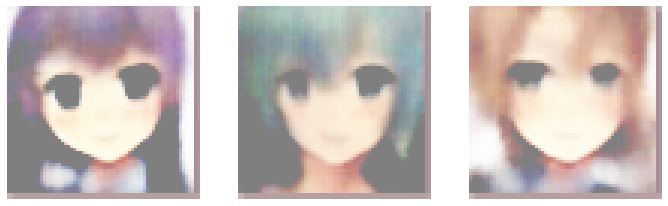

In [30]:
some = generate(model,3,device)
show_images(some, tensor=True)

In [31]:
start_epoch =  101


for epoch in range(start_epoch, 150 + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)

    train_losses.append((epoch, train_loss))

Sat May 15 18:36:46 2021 Train Epoch: 101 [0/10913 (0%)]	Loss: 6720.990234
Sat May 15 18:37:42 2021 Train Epoch: 101 [6400/10913 (58%)]	Loss: 6668.082520
Train set Average loss: 6715.326377467105
Sat May 15 18:38:24 2021 Train Epoch: 102 [0/10913 (0%)]	Loss: 6595.124023
Sat May 15 18:39:18 2021 Train Epoch: 102 [6400/10913 (58%)]	Loss: 6666.497559
Train set Average loss: 6715.299550552814
Sat May 15 18:39:56 2021 Train Epoch: 103 [0/10913 (0%)]	Loss: 6641.368164
Sat May 15 18:40:52 2021 Train Epoch: 103 [6400/10913 (58%)]	Loss: 6877.371582
Train set Average loss: 6715.472247921235
Sat May 15 18:41:30 2021 Train Epoch: 104 [0/10913 (0%)]	Loss: 6584.061035
Sat May 15 18:42:24 2021 Train Epoch: 104 [6400/10913 (58%)]	Loss: 6849.449707
Train set Average loss: 6715.370100054824
Sat May 15 18:43:02 2021 Train Epoch: 105 [0/10913 (0%)]	Loss: 6742.558105
Sat May 15 18:43:57 2021 Train Epoch: 105 [6400/10913 (58%)]	Loss: 6701.413574
Train set Average loss: 6714.606376781799
Sat May 15 18:44:35 

Sat May 15 20:14:25 2021 Train Epoch: 143 [0/10913 (0%)]	Loss: 6771.819336
Sat May 15 20:15:22 2021 Train Epoch: 143 [6400/10913 (58%)]	Loss: 6613.234375
Train set Average loss: 6709.57629751462
Sat May 15 20:16:02 2021 Train Epoch: 144 [0/10913 (0%)]	Loss: 6772.355957
Sat May 15 20:16:58 2021 Train Epoch: 144 [6400/10913 (58%)]	Loss: 6760.918945
Train set Average loss: 6709.042391949927
Sat May 15 20:17:37 2021 Train Epoch: 145 [0/10913 (0%)]	Loss: 6588.852051
Sat May 15 20:18:33 2021 Train Epoch: 145 [6400/10913 (58%)]	Loss: 6744.796387
Train set Average loss: 6709.266030473319
Sat May 15 20:19:12 2021 Train Epoch: 146 [0/10913 (0%)]	Loss: 6731.493164
Sat May 15 20:20:08 2021 Train Epoch: 146 [6400/10913 (58%)]	Loss: 6693.715332
Train set Average loss: 6708.814738669591
Sat May 15 20:20:48 2021 Train Epoch: 147 [0/10913 (0%)]	Loss: 6891.914551
Sat May 15 20:21:44 2021 Train Epoch: 147 [6400/10913 (58%)]	Loss: 6736.205078
Train set Average loss: 6708.776644165753
Sat May 15 20:22:23 2

<ipython-input-18-2b7accf13b3d>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, ii + 1)


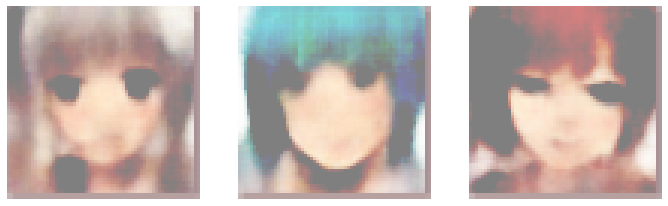

In [34]:
some = generate(model,3,device)
show_images(some, tensor=True)

In [35]:
start_epoch =  151


for epoch in range(start_epoch, 200 + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)

    train_losses.append((epoch, train_loss))

Sat May 15 20:59:37 2021 Train Epoch: 151 [0/10913 (0%)]	Loss: 6522.008789
Sat May 15 21:00:31 2021 Train Epoch: 151 [6400/10913 (58%)]	Loss: 6703.127441
Train set Average loss: 6708.020918996711
Sat May 15 21:01:10 2021 Train Epoch: 152 [0/10913 (0%)]	Loss: 6869.090820
Sat May 15 21:02:03 2021 Train Epoch: 152 [6400/10913 (58%)]	Loss: 6656.083496
Train set Average loss: 6708.183796486659
Sat May 15 21:02:41 2021 Train Epoch: 153 [0/10913 (0%)]	Loss: 6771.439453
Sat May 15 21:03:34 2021 Train Epoch: 153 [6400/10913 (58%)]	Loss: 6732.916992
Train set Average loss: 6709.155830249451
Sat May 15 21:04:12 2021 Train Epoch: 154 [0/10913 (0%)]	Loss: 6638.275391
Sat May 15 21:05:06 2021 Train Epoch: 154 [6400/10913 (58%)]	Loss: 6653.643555
Train set Average loss: 6707.06834509777
Sat May 15 21:05:45 2021 Train Epoch: 155 [0/10913 (0%)]	Loss: 6597.984863
Sat May 15 21:06:38 2021 Train Epoch: 155 [6400/10913 (58%)]	Loss: 6670.780273
Train set Average loss: 6707.791215506213
Sat May 15 21:07:16 2

KeyboardInterrupt: 

<ipython-input-18-2b7accf13b3d>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, ii + 1)


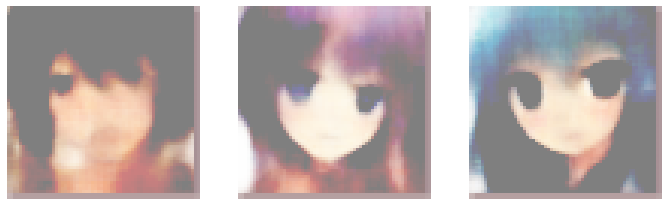

In [41]:
some = generate(model,3,device)
show_images(some, tensor=True)

In [42]:
start_epoch =  172


for epoch in range(start_epoch, 200 + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)

    train_losses.append((epoch, train_loss))

Sat May 15 22:51:51 2021 Train Epoch: 172 [0/10913 (0%)]	Loss: 6718.487305
Sat May 15 22:52:45 2021 Train Epoch: 172 [6400/10913 (58%)]	Loss: 6518.845703
Train set Average loss: 6707.358738235563
Sat May 15 22:53:23 2021 Train Epoch: 173 [0/10913 (0%)]	Loss: 6656.989746
Sat May 15 22:54:17 2021 Train Epoch: 173 [6400/10913 (58%)]	Loss: 6797.916504
Train set Average loss: 6706.1575720714545
Sat May 15 22:54:54 2021 Train Epoch: 174 [0/10913 (0%)]	Loss: 6581.475098
Sat May 15 22:55:48 2021 Train Epoch: 174 [6400/10913 (58%)]	Loss: 6655.651367
Train set Average loss: 6707.567151521382
Sat May 15 22:56:26 2021 Train Epoch: 175 [0/10913 (0%)]	Loss: 6815.335938
Sat May 15 22:57:19 2021 Train Epoch: 175 [6400/10913 (58%)]	Loss: 6677.883789
Train set Average loss: 6705.780516150402
Sat May 15 22:57:57 2021 Train Epoch: 176 [0/10913 (0%)]	Loss: 6740.818359
Sat May 15 22:58:50 2021 Train Epoch: 176 [6400/10913 (58%)]	Loss: 6766.950195
Train set Average loss: 6706.879308867873
Sat May 15 22:59:27

<ipython-input-18-2b7accf13b3d>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, ii + 1)


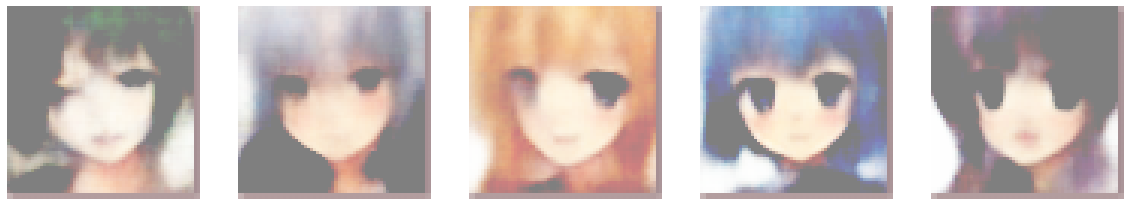

In [57]:
some = generate(model,5,device)
show_images(some, tensor=True)